# Example 4: Confidence intervals

This example approximates confidence intervals for peak location using either sampling within each grid-field's Voronoi region, or a Quadratic approximation at the peak. 

Neuron `r2405_051216b_cell1816` was recorded by Dr. Marius Bauza and the Krupic lab; They have kindly shared this data to evaluate these GP methods. Please cite their work as

> Krupic J, Bauza M, Burton S, O’Keefe J. Local transformations of the hippocampal cognitive map. Science. 2018 Mar 9;359(6380):1143-6.

## Retrieve data and obtain posterior log-rate map

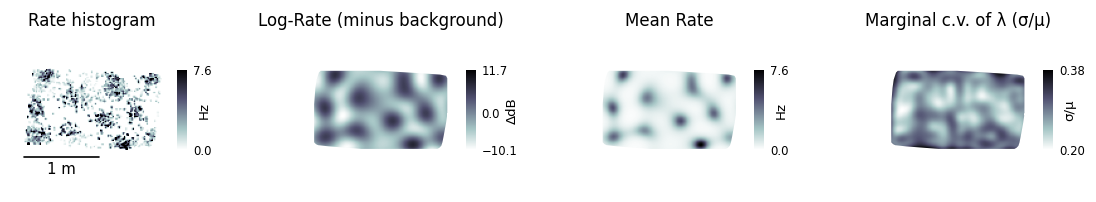

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
from lgcpspatial.loaddata import Dataset
from lgcpspatial.lgcp2d   import DiagonalFourierLowrank
from lgcpspatial.lgcp2d   import coordinate_descent
from lgcpspatial.plot     import *

# Load dataset R11_20190607_EC_02
L        = 128 # Grid size for position bins
dataset  = 'r2405_051216b_cell1816.mat'
fn       = '../example data/' + dataset
data     = Dataset.from_file(fn)
data.prepare(L)

# Infer using optimized parameters
# These parameters were computed in example 3
P        = 23.58975  # Grid period
kv       = 0.4109905 # Log-rate prior covariance kernel peak variance (zero lag variance)
model    = DiagonalFourierLowrank(kv,P,data)
fit      = coordinate_descent(model,tol=1e-3)
#low_rank_posterior_mean,posterior_variance,vfe = fit
inference_summary_plot(model,fit,data);

## Confidence intervals via sampling or quadratic approximation

[23.096508 23.113163 22.509035 23.107924 23.759508 23.587437 23.267763
 27.616806 23.598854]


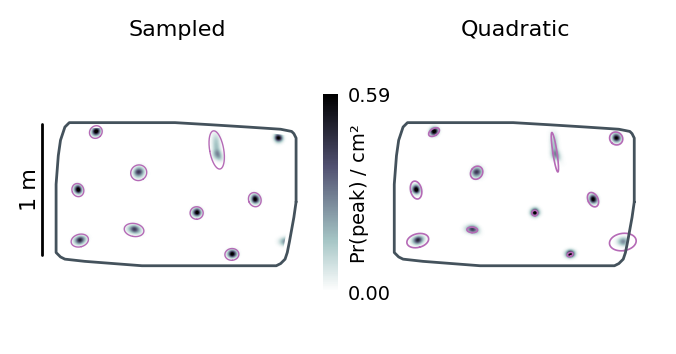

In [2]:
from lgcpspatial.posterior import SampledConfidence, QuadraticConfidence

resolution          = 2     # Upsampling resolution
exclusion_radius    = 1/2.5 # Limit field radius/collisions
edge_radius         = 1/5   # Drop peaks this close to edge
nsamples            = 2000  # Number of samples
localization_radius = 0.75  # Drop peaks with confidence outside this radius

figure(figsize=(4,2),dpi=200)
subplot(121)
confidence = SampledConfidence(
    data,                   # Dataset
    model,                  # Model
    fit,                    # Fitted result
    exclusion_radius,       # Use local maxima within this radius
    edge_radius,            # Delete close to edge
    resolution,             # Updampling
    nsamples,               # Samples to use
    height_threshold = 0.95,# Amplitude threshold for peaks
    prpeak_threshold = 0.0, # Fraction of samples peak must be present to include
    doplot           = True,
    color            = MAUVE,
    cmap             = 'bone_r')
title('Sampled')
xlim(0,1); ylim(0,1);
plot(*data.arena.perimeter.T,lw=1,color=BLACK)

subplot(122)
# Confidence intervals directly from the posterior:
# A locally-quadratic approximation of the peak, disrupted 
# by the expected gradient of the posterior covariance, is 
# sufficient for getting confidence intervals for well-
# localized peaks. 
qconfidence = QuadraticConfidence(
    data,                   # Dataset
    model,                  # Model
    fit,                    # Fitted result
    exclusion_radius,       # Peak neighorhood clearance
    localization_radius,    # Peak confidence threshold
    height_threshold = 0.6, # Amplitude threshold for peaks
    edge_radius      = edge_radius,
    doplot           = True,
    draw_border      = False)
title('Quadratic')
xlim(0,1); ylim(0,1);

vmax = ceil(percentile(
    confidence.samples.kde[confidence.arena.mask],99.9)*100)/100
imshow(confidence.samples.kde*confidence.arena.nanmask,
    extent = (0,1)*2,
    cmap   = 'bone_r',
    vmin   = 0,
    vmax   = vmax,
    origin = 'lower')
plot(*data.arena.perimeter.T,lw=1,color=BLACK)